In [163]:
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-dark-palette')

# Preparing Data

In [188]:
data = np.loadtxt('data/data_spectrum.csv')
params = np.loadtxt('data/params_spectrum.csv')
print(data.shape)
print(params.shape)

(10000, 128)
(10000, 2)


In [189]:
data_log = np.log(data)
data_log_norm = (data_log - np.mean(data_log))/np.var(data_log)
np.savetxt('data/data_log_norm_spectrum.csv' , data_log_norm)


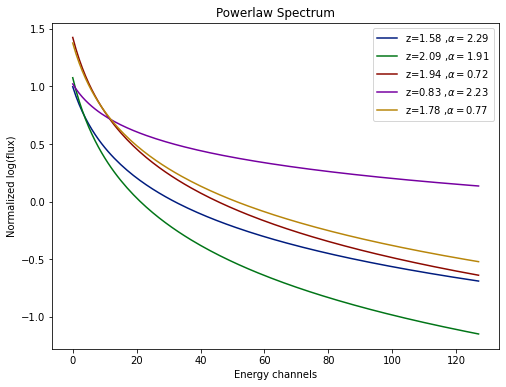

In [169]:
fig = plt.figure(figsize=(8,6))
for i in range(5):
    plt.plot(data_log_norm[i])
plt.xlabel('Energy channels')
plt.ylabel('Normalized log(flux)')
plt.title('Powerlaw Spectrum')
legends = [r'z={:.2f} ,$\alpha = ${:.2f}'.format(p[0],p[1]) for p in params[0:5]]
plt.legend(legends)
plt.savefig('plots/Data_plot.png')
plt.show()

# Regression Neural Network

In [170]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.1


In [171]:
def pred_model(l_struct):
  '''
  Prediction Model
  Returns A fully-connencted Model for 
  Network structure given by number of 
  layers in the input argument.
  Argument l_struct basically encodes the 
  information about layer structure.
  '''
  inp = keras.Input(shape=(128 , ))
  x = layers.Dense(l_struct[0] , activation='relu')(inp)
  l_struct = l_struct[1:]
  for l in l_struct:
    x = layers.Dense(l, activation='relu')(x)
  op = layers.Dense(2, activation='relu')(x)
  model = keras.Model(inputs=inp , outputs=op , name = 'regressor')
  return model

In [176]:
model = pred_model([64,64,32])
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
model.summary()

Model: "regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_141 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_142 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_143 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_144 (Dense)            (None, 2)                 66        
Total params: 14,562
Trainable params: 14,562
Non-trainable params: 0
_________________________________________________________________


In [177]:
history = model.fit(data_log_norm, params,validation_split=0.2, epochs=60)

Epoch 1/60
250/250 [==============================] - 0s 1ms/step - loss: 0.3110 - val_loss: 0.2862
Epoch 2/60
250/250 [==============================] - 0s 987us/step - loss: 0.2515 - val_loss: 0.2234
Epoch 3/60
250/250 [==============================] - 0s 964us/step - loss: 0.1704 - val_loss: 0.1045
Epoch 4/60
250/250 [==============================] - 0s 965us/step - loss: 0.0865 - val_loss: 0.0600
Epoch 5/60
250/250 [==============================] - 0s 1ms/step - loss: 0.0579 - val_loss: 0.0459
Epoch 6/60
250/250 [==============================] - 0s 972us/step - loss: 0.0545 - val_loss: 0.0439
Epoch 7/60
250/250 [==============================] - 0s 986us/step - loss: 0.0432 - val_loss: 0.0530
Epoch 8/60
250/250 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 0.0548
Epoch 9/60
250/250 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0346
Epoch 10/60
250/250 [==============================] - 0s 1ms/step - loss: 0.0322 - val_lo

In [187]:
print(model.predict(data_log_norm[10:15]))
print(params[10:15])

[[1.9583586  2.0770087 ]
 [2.4124749  1.2557209 ]
 [2.4208643  1.0756073 ]
 [0.75826734 1.8113971 ]
 [2.113911   0.6162281 ]]
[[1.97569673 2.07664007]
 [2.44035141 1.26960575]
 [2.44748619 1.09005667]
 [0.76324788 1.66898107]
 [2.1193162  0.61619085]]


In [180]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


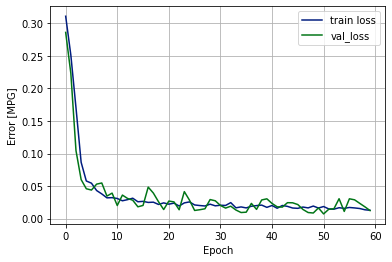

In [181]:
plot_loss(history)

In [182]:
model.save('fc_model')

INFO:tensorflow:Assets written to: fc_model/assets


## HyperParameter Tuning

In [183]:
from sklearn.metrics import mean_squared_error

In [184]:
def train_test_split(data, params , split):
    split = 1-split
    n_split = int(len(data)*split)
    d_list = [[d,p] for d,p in zip(data, params)]
    d_list = np.asarray(d_list)
    np.random.shuffle(d_list)
    d_list_train = d_list[:n_split,:]
    d_list_test = d_list[n_split:,:]

    train_data = d_list_train[:,0]
    train_data = np.asarray([t for t in train_data])
    test_data = d_list_test[:,0]
    test_data = np.asarray([t for t in test_data])
    
    train_p = d_list_train[:,1]
    train_p = np.asarray([t for t in train_p])

    test_p = d_list_test[:,1]
    test_p = np.asarray([t for t in test_p])

    return (train_data , train_p) , (test_data , test_p)

In [185]:
def model_score(model , data , params , plot=False , epochs = 20 , verbose = 0):

    def plot_loss(history):
        plt.plot(history.history['loss'], label='train loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        #plt.ylim([0, 10])
        plt.xlabel('Epoch')
        plt.ylabel('Error [MPG]')
        plt.legend()
        plt.grid(True)
        plt.show()

    (train_data, train_p) , ( test_data , test_p) = train_test_split(data , params , 0.2)

    history = model.fit(train_data, train_p,validation_split=0.2, epochs=epochs , verbose=verbose)

    if(plot):
        plot_loss(history)

    y_true_test = np.copy(test_p)
    y_pred_test = model.predict(test_data)

    y_true_train = np.copy(train_p)
    y_pred_train = model.predict(train_data)
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    mse_test = mean_squared_error(y_true_test, y_pred_test)
    model.summary()
    return mse_train , mse_test 

In [186]:
model = pred_model([64,64,32,32])
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

model_losses = model_tuning(model , data_log_norm , params , verbose = 0)
print(model_losses)

Model: "regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_145 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_146 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_147 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_148 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_149 (Dense)            (None, 2)                 66        
Total params: 15,618
Trainable params: 15,618
Non-trainable params: 0
_____________________________________________________